# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [156]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [157]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [158]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=220.07232580702924, mobile=True), User(purchased=True, time_on_site=277.7846251540128, mobile=True), User(purchased=False, time_on_site=28.74146622426043, mobile=False), User(purchased=True, time_on_site=171.3992508610535, mobile=False), User(purchased=True, time_on_site=28.885269643885692, mobile=True), User(purchased=True, time_on_site=197.70352006279268, mobile=True), User(purchased=False, time_on_site=41.060071404567616, mobile=True), User(purchased=False, time_on_site=259.9732981239484, mobile=True), User(purchased=True, time_on_site=65.51033903118966, mobile=True), User(purchased=False, time_on_site=76.66110399051816, mobile=False)]


In [159]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,220.072326,True
1,True,277.784625,True
2,False,28.741466,False
3,True,171.399251,False
4,True,28.885270,True


In [160]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,6.377085327373235,7.03512240132684,7.42760148581928,7.560808902649134,7.570601026793545,7.893963409556175,7.916424755235623,8.14667302345102,8.188874317154434,8.540473596473518,9.396488878515441,9.831062408883216,10.286302235312588,10.672948752664745,10.92448292831435,11.080586215528204,11.743194236877818,12.110276835420088,12.361141977458079,13.987238556874198,14.028215479221895,14.338188015761848,14.418948441685165,14.879967875292087,14.947955458583365,15.183372835910047,15.333680325633694,15.866552092491613,15.923205681885934,15.941223001105788,15.998333420434697,16.091476906099963,16.6685671822143,16.78786275752499,18.29453546847173,18.48803522149192,19.231632357910186,19.50538953842919,19.60344002713724,20.08636739400813,...,490.85183251738516,490.97860439728294,491.6939265121603,492.56216625110784,496.9330865840208,499.76554557473105,500.7592780448502,503.32704238071113,504.3714274860914,506.6985416278378,508.77227177017335,518.0600812252401,525.9353362537236,525.9807836828534,527.1764562522493,533.3387067308224,535.4523764399295,536.9136923338253,536.9383694271098,538.8479849026397,541.0125638914568,541.3140645013016,542.7256476482257,543.3748063801164,544.3940541064039,545.7875138591307,553.7440265680674,553.9891263847039,560.3593392401414,564.7000693218043,567.4392007250036,568.5541587922827,572.88674731936,574.6156498476806,575.2242283433989,575.262549125294,580.1070349936797,584.9714604707855,590.9891258317901,597.8562652209705
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,1,1,0,1,1
True,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,1,0,0,0,1,1,0,1,1,0,1,1,1,0,0,1,0,1,0,0,0,1,0,0


In [161]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.786, 124.673]","(124.673, 242.969]","(242.969, 361.265]","(361.265, 479.56]","(479.56, 597.856]"
purchased,,,,,
False,250,239,98,30,29
True,113,140,70,13,18


In [162]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.786, 124.673]","(124.673, 242.969]","(242.969, 361.265]","(361.265, 479.56]","(479.56, 597.856]"
purchased,,,,,
False,0.688705,0.630607,0.583333,0.697674,0.617021
True,0.311295,0.369393,0.416667,0.302326,0.382979


In [163]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.744,0.613333
True,0.256,0.386667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [165]:
#Import the csv and make the first column the index so that we don't have two
df = pd.read_csv('https://raw.githubusercontent.com/ChanceDurr/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', 
                 index_col='Unnamed: 0')
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [166]:
df.isnull().sum() #Check for NaN values

df.describe() #Check basic data values

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [167]:
#revert back to old pandas for crosstab
!pip install pandas==0.23.4

In [168]:
#Create a bin for ages, weight, and exercise time
time_bins = pd.cut(df.exercise_time, bins=5, ,
                   labels=['0-1 hours', '1-2 hours', '2-3 hours', '3-4 hours', '4-5 hours'])
age_bins = pd.cut(df.age, [0, 10, 20, 30, 40, 50, 60, 70, 80])

weight_bins = pd.cut(df.weight, [100, 120, 140, 160, 180, 200, 220, 240])

#create a pandas cross tab with age and time bins
pd.crosstab(age_bins, time_bins)

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(10, 20]",9,18,10,15,8
"(20, 30]",43,28,44,46,35
"(30, 40]",44,46,34,41,48
"(40, 50]",32,35,29,25,49
"(50, 60]",28,42,36,32,46
"(60, 70]",49,68,44,32,5
"(70, 80]",73,79,26,1,0


In [169]:
#create a crosstab with weight and exercise time
pd.crosstab(weight_bins, time_bins)

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(100, 120]",33,36,50,48,64
"(120, 140]",32,55,48,58,76
"(140, 160]",31,55,44,46,41
"(160, 180]",36,63,34,29,6
"(180, 200]",48,54,43,7,0
"(200, 220]",58,47,3,0,0
"(220, 240]",30,5,0,0,0


In [170]:
pd.crosstab(age_bins, weight_bins)

weight,"(100, 120]","(120, 140]","(140, 160]","(160, 180]","(180, 200]","(200, 220]","(220, 240]"
age,,,,,,,
"(10, 20]",11,13,13,8,10,5,0
"(20, 30]",52,35,45,27,17,14,5
"(30, 40]",53,52,31,26,23,20,4
"(40, 50]",33,52,29,26,13,12,2
"(50, 60]",34,42,34,26,24,19,1
"(60, 70]",25,44,42,27,30,18,8
"(70, 80]",23,31,23,28,35,20,15


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

##1.  **What are the variable types in the data?**

*   Age - discrete
*   Weight - continuous, binned to discrete
*   Exercise - continuous, binned to discrete

##2.  What are the relationships between the variables?

*   As age increased amount of people working out longer times decreased
*   As weight increased amount of people working out longer times decreased
*   Their wasn't a huge correlation between age and weight

##3.  Which relationships are "real", and which spurious?

*   I'd say the age-exercise and weight-exercise were real and the age-weight was spurious


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

In [171]:
import numpy as np
#Create the array of data for a DataFrame
array = np.array([[2010, 2759, 114.9],
                  [2011, 2442, 163],
                  [2012, 2594, 227.8],
                  [2013, 2736, 307.4],
                  [2014, 3123, 397.4],
                  [2015, 3772, 486.7],
                  [2016, 4505, 583.8],
                  [2017, 5485, 673.4],
                  [2018, 6320, 759.3]])

df = pd.DataFrame(homeless_array, columns=['year', 'homeless', 'tvs'], dtype=int)
df.head()

,year,homeless,tvs
0,2010,2759,114
1,2011,2442,163
2,2012,2594,227
3,2013,2736,307
4,2014,3123,397


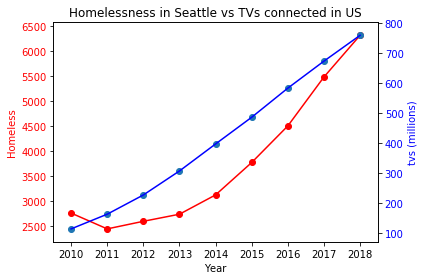

The Correlation is 94.72%


In [173]:
import matplotlib.pyplot as plot

fig, ax1 = plot.subplots()

#Set the X and Y labels and make all of the first Y values red
color = 'red'
ax1.set_title('Homelessness in Seattle vs TVs connected in US')
ax1.set_xlabel('Year')
ax1.set_ylabel('Homeless', color = color)
ax1.plot(df.year, df.homeless, color = color)
ax1.tick_params(axis='y', labelcolor=color)
plot.scatter(df.year, df.homeless, color = color)

#create another y value witht the same X
ax2 = ax1.twinx()

#Change the second y values to all blue
color ='blue'
ax2.set_ylabel('tvs (millions)', color = color)
ax2.plot(df.year, df.tvs, color = color)
ax2.tick_params(axis='y', labelcolor=color)
plot.scatter(df.year, df.tvs)


fig.tight_layout() #Use this to make it so second y ticks dont clip
plot.show()

corr = np.corrcoef(df.homeless, df.tvs)[0, 1] # Get the Correlation between the two
print(f'The Correlation is {(corr * 100).round(2)}%')